Questions for Carolyn:
- standard scaler with values - is this not affecting anything and we can ignore it?
- from some results it looks like treated-24h performs the best --- should we do predictions on just those?
- might there be a way to combine different feature selection for different dataframes - combine the result to give better predictions?

Tasks still to try:
- cosine similarity (as feature selection tool .. between reps to see which features to keep)
- recursive feature elimination
- spearman rank - likely to be different for the different dataframes
- PCA? maybe this changes for the different dataframes
- random forest - gridsearch
- apply random forest to feature selection tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, Ridge, LassoCV, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import make_scorer

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## #1. Prepare dataframes

**1a) Create full dataframe containing all features**

In [2]:
train_full = pd.read_csv("SubCh1_TrainingData.csv")
test_full = pd.read_csv("SubCh1_TestData.csv")

train_full['Timepoint'] = [1 if i == '24HR' else 0 for i in train_full['Timepoint']]
train_full['Treatment'] = [1 if i == 'DHA' else 0 for i in train_full['Treatment']]
train_full['BioRep'] = [int(i[-1]) for i in train_full['BioRep']]
train_full = train_full.drop(['Sample_Name', 'Isolate'], axis = 1)

y = train_full[['DHA_IC50']]
print(y.shape)
print(train_full.shape)

train_full.head()

(272, 1)
(272, 5544)


Timepoint  Treatment  BioRep  MAL1.465720.465873.bc..rv..  \
0          1          1       1                     0.008286   
1          1          1       2                    -0.872028   
2          1          0       1                     0.039480   
3          1          0       2                     0.125177   
4          0          1       1                     1.354956   

   MAL1.48287.48430....kr...can  MAL1.562126.562246.bc..r...  \
0                     -0.959492                     0.206468   
1                     -1.968558                    -2.308563   
2                     -1.291371                    -0.946661   
3                     -1.462758                    -1.888105   
4                     -2.139128                    -0.541696   

   MAL1.59416.59687....kr...can  MAL1.616633.616682.......y.  \
0                     -0.443936                     0.453030   
1                     -1.186611                     0.508575   
2                     -0.538092                    -1.778501   
3                     -0.828352                    -1.410803   
4                     -1.481881                    -0.735798   

   MAL10.1139073.1139243....kr  MAL10.258733.258825.b...r..    ...     \
0                     0.291222                    -0.157282    ...      
1                    -0.368476                     2.566465    ...      
2                     1.037573                     1.733154    ...      
3                     0.926191                     2.644319    ...      
4                    -0.129961                     2.707328    ...      

   PF3D7_1479200  PF3D7_1479400  PF3D7_1479500  PF3D7_1479600  PF3D7_1479700  \
0      -0.540993      -3.674097      -1.652979      -2.255490      -4.554757   
1       0.450649      -4.464408      -0.977954      -2.012559      -4.538550   
2       1.411557      -5.500522      -1.764229      -1.947208      -5.331037   
3      -0.659519      -5.011207      -0.559471      -2.266763      -5.289318   
4      -1.687048      -4.773306      -0.048847      -2.023727      -4.398358   

   PF3D7_1479800  PF3D7_1479900  PF3D7_1480000  PF3D7_1480100  DHA_IC50  
0      -0.381422      -1.415857      -4.121011      -2.486528     2.177  
1      -2.333890      -2.342496      -4.774197      -1.794568     2.177  
2      -0.814417      -2.141285      -3.922684      -2.495169     2.177  
3      -2.949869      -2.206432      -4.324299      -1.735312     2.177  
4      -3.080500      -0.566545      -4.798190      -0.821690     2.177  

[5 rows x 5544 columns]

**1b) Create different dataframes for all the different combinations possible** 

In [5]:
range(1, len(train.columns))

range(1, 5540)

In [4]:
train = train_full.drop(['BioRep', 'DHA_IC50', 'Timepoint', 'Treatment'], axis=1)
train.columns = ['X' + str(i) for i in range(1, 5541)]
train.head()  #train  = all genes only

X1        X2        X3        X4        X5        X6        X7  \
0  0.008286 -0.959492  0.206468 -0.443936  0.453030  0.291222 -0.157282   
1 -0.872028 -1.968558 -2.308563 -1.186611  0.508575 -0.368476  2.566465   
2  0.039480 -1.291371 -0.946661 -0.538092 -1.778501  1.037573  1.733154   
3  0.125177 -1.462758 -1.888105 -0.828352 -1.410803  0.926191  2.644319   
4  1.354956 -2.139128 -0.541696 -1.481881 -0.735798 -0.129961  2.707328   

         X8        X9       X10    ...        X5531     X5532     X5533  \
0 -1.676810  0.377070  0.330400    ...     0.210607 -0.540993 -3.674097   
1  0.366850  1.289160 -0.513018    ...    -0.447109  0.450649 -4.464408   
2  1.454916  2.330948 -1.758676    ...    -0.780016  1.411557 -5.500522   
3 -0.539311  0.072951  0.256755    ...     0.199611 -0.659519 -5.011207   
4 -0.078783  1.058127 -1.449748    ...    -2.174257 -1.687048 -4.773306   

      X5534     X5535     X5536     X5537     X5538     X5539     X5540  
0 -1.652979 -2.255490 -4.554757 -0.381422 -1.415857 -4.121011 -2.486528  
1 -0.977954 -2.012559 -4.538550 -2.333890 -2.342496 -4.774197 -1.794568  
2 -1.764229 -1.947208 -5.331037 -0.814417 -2.141285 -3.922684 -2.495169  
3 -0.559471 -2.266763 -5.289318 -2.949869 -2.206432 -4.324299 -1.735312  
4 -0.048847 -2.023727 -4.398358 -3.080500 -0.566545 -4.798190 -0.821690  

[5 rows x 5540 columns]

In [6]:
X_one = train.loc[:]
print('X_one', X_one.shape, y.shape)

X_two = train.loc[:]
X_two['Treatment'] =  train_full['Treatment']
X_two['Timepoint'] = train_full['Timepoint'] 
print('X_two', X_two.shape)

X_three = train.loc[:]
X_three['Treatment'] =  train_full['Treatment']
print('X_three', X_three.shape)

# dataframes with selected rows
X_treated = X_two[(X_two['Treatment']==1)]
y_treated = train_full[(train_full['Treatment']==1)][['DHA_IC50']]
print('X_treated', X_treated.shape, y_treated.shape)

X_treated_24 = X_two[(X_two['Treatment']==1) & (X_two['Timepoint'] ==1)]
y_treated_24 = train_full[(train_full['Treatment']==1)&(train_full['Timepoint'] == 1)][['DHA_IC50']]
print('X_treated_24', X_treated_24.shape, y_treated_24.shape)


X_treated_6 = X_two[(X_two['Treatment']==1) & (X_two['Timepoint'] ==0)]
y_treated_6 = train_full[(train_full['Treatment']==1)&(train_full['Timepoint'] == 0)][['DHA_IC50']]
print('X_treated_6', X_treated_6.shape, y_treated_6.shape)

X_untreated = X_two[(X_two['Treatment']==0)]
y_untreated = train_full[(train_full['Treatment']==0)][['DHA_IC50']]
print('X_untreated', X_untreated.shape, y_untreated.shape)

X_untreated_24 = X_two[(X_two['Treatment']==0) & (X_two['Timepoint'] ==1)]
y_untreated_24 = train_full[(train_full['Treatment']==0)&(train_full['Timepoint'] == 1)][['DHA_IC50']]
print('X_untreated_24', X_untreated_24.shape, y_untreated_24.shape)

X_untreated_6 = X_two[(X_two['Treatment']==0) & (X_two['Timepoint'] ==0)]
y_untreated_6 = train_full[(train_full['Treatment']==0)&(train_full['Timepoint'] == 0)][['DHA_IC50']]
print('X_untreated_6', X_untreated_6.shape, y_untreated_6.shape)




X_two.head()

X_one (272, 5540) (272, 1)
X_two (272, 5542)
X_three (272, 5541)
X_treated (136, 5542) (136, 1)
X_treated_24 (68, 5542) (68, 1)
X_treated_6 (68, 5542) (68, 1)
X_untreated (136, 5542) (136, 1)
X_untreated_24 (68, 5542) (68, 1)
X_untreated_6 (68, 5542) (68, 1)


X1        X2        X3        X4        X5        X6        X7  \
0  0.008286 -0.959492  0.206468 -0.443936  0.453030  0.291222 -0.157282   
1 -0.872028 -1.968558 -2.308563 -1.186611  0.508575 -0.368476  2.566465   
2  0.039480 -1.291371 -0.946661 -0.538092 -1.778501  1.037573  1.733154   
3  0.125177 -1.462758 -1.888105 -0.828352 -1.410803  0.926191  2.644319   
4  1.354956 -2.139128 -0.541696 -1.481881 -0.735798 -0.129961  2.707328   

         X8        X9       X10    ...         X5533     X5534     X5535  \
0 -1.676810  0.377070  0.330400    ...     -3.674097 -1.652979 -2.255490   
1  0.366850  1.289160 -0.513018    ...     -4.464408 -0.977954 -2.012559   
2  1.454916  2.330948 -1.758676    ...     -5.500522 -1.764229 -1.947208   
3 -0.539311  0.072951  0.256755    ...     -5.011207 -0.559471 -2.266763   
4 -0.078783  1.058127 -1.449748    ...     -4.773306 -0.048847 -2.023727   

      X5536     X5537     X5538     X5539     X5540  Treatment  Timepoint  
0 -4.554757 -0.381422 -1.415857 -4.121011 -2.486528          1          1  
1 -4.538550 -2.333890 -2.342496 -4.774197 -1.794568          1          1  
2 -5.331037 -0.814417 -2.141285 -3.922684 -2.495169          0          1  
3 -5.289318 -2.949869 -2.206432 -4.324299 -1.735312          0          1  
4 -4.398358 -3.080500 -0.566545 -4.798190 -0.821690          1          0  

[5 rows x 5542 columns]

|df name|Description|shape| y to use|
|---|---|---|---|
|X_one|genes only |272, 5540|y|
|X_two|treat = [0,1] time = [0,1] | 272, 5542|y|
|X_three|treat = [0,1] |272, 5541| 272, 5541|y|
|X_treated|treat = [1] time = [0,1]| 136, 5542|y_treated|
|X_treated_24|treat = [1] time = [1]| 68, 5542|y_treated_24|
|X_treated_6|treat = [1] time = [0]| 68, 5542|y_treated_6|
|X_untreated|treat = [0] time = [0,1]|136, 5542|y_untreated|
|X_untreated_24|treat = [0], time = [1]| 68, 5542|y_untreated_24|
|X_untreated_6|treat = [0], time = [0]| 68, 5542|y_untreated_6|

## #2. For SVM model, Gridsearch the best params for each dataframe

In [7]:
def spear_r(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

In [439]:
# example of how globals works

X_frames = ['X_one', 'X_two', 'X_three', 'X_treated', 'X_treated_24', 'X_treated_6',
            'X_untreated', 'X_untreated_24','X_untreated_6' ]
y_frames = ['y', 'y', 'y', 'y_treated', 'y_treated_24', 'y_treated_6',
            'y_untreated', 'y_untreated_24', 'y_untreated_6']

for x in list(zip(X_frames, y_frames)):

    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    print(x[0], x_frame.shape, x[1], y_frame.shape)


X_one (272, 5540) y (272, 1)
X_two (272, 5542) y (272, 1)
X_three (272, 5541) y (272, 1)
X_treated (136, 5542) y_treated (136, 1)
X_treated_24 (68, 5542) y_treated_24 (68, 1)
X_treated_6 (68, 5542) y_treated_6 (68, 1)
X_untreated (136, 5542) y_untreated (136, 1)
X_untreated_24 (68, 5542) y_untreated_24 (68, 1)
X_untreated_6 (68, 5542) y_untreated_6 (68, 1)



- The gridsearch code block under **Cosine similarity between bioreps** is better to use
- regarding `dataframe_gridsearch` below:
    - I don't know why I wrote this as a function. dumb 
    - Also using df.iloc (in last 4 lines) was not ideal because the gridsearch columns change with different params  to search thru

In [440]:
def dataframe_gridsearch():
    X_frames = ['X_one', 'X_two', 'X_three', 'X_treated', 'X_treated_24', 'X_untreated', 'X_untreated_24' ]
    y_frames = ['y', 'y', 'y', 'y_treated', 'y_treated_24', 'y_untreated', 'y_untreated_24']
#     X_frames = ['X_one']
#     y_frames = ['y']
    df = pd.DataFrame(columns=['best_params', 'test_spear', 'test_r2', 'train_spear', 'train_r2', 'best_spear'])
    
    for x in list(zip(X_frames, y_frames)):
        x_frame = globals()[x[0]]
        y_frame = globals()[x[1]]
        
        X_train, X_test, y_train, y_test = train_test_split(x_frame, y_frame.values.ravel(), test_size = 0.33, random_state = 33)

        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.1, 1, 10, 50],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 3, 4],

                 }


        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r)}

        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')

        gs.fit(X_train, y_train) 
        scores = pd.DataFrame(gs.cv_results_)
        condition = scores['rank_test_spear_r'] == 1
        df_1 = scores[condition]
   
        df.loc[x[0]] = (df_1.iloc[0, 9], round(df_1.iloc[0, 24], 3), round(df_1.iloc[0, 13], 3), 
                 round(df_1.iloc[0, 30], 3), round(df_1.iloc[0, 19], 3), round(gs.best_score_, 3))
#       
    return df
results = dataframe_gridsearch()

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

In [441]:
results


best_params  test_spear  \
X_one           {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma':...       0.225   
X_two           {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma':...       0.225   
X_three         {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma':...       0.225   
X_treated       {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamm...       0.277   
X_treated_24    {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma':...       0.419   
X_treated_6     {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma':...       0.362   
X_untreated     {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...       0.214   
X_untreated_24  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.259   
X_untreated_6   {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamm...       0.153   

                test_r2  train_spear  train_r2  best_spear  
X_one            -0.079        0.878     0.582       0.225  
X_two            -0.079        0.878     0.582       0.225  
X_three          -0.079        0.878     0.582       0.225  
X_treated        -0.038        0.697     0.192       0.277  
X_treated_24     -0.161        0.998     0.875       0.419  
X_treated_6       0.009        0.909     0.576       0.362  
X_untreated      -0.076        0.830     0.233       0.214  
X_untreated_24   -0.181        0.975     0.799       0.259  
X_untreated_6    -0.175        0.611     0.143       0.153

In [442]:
results['best_params'].values

array([{'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'},
       {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'},
       {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'},
       {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}],
      dtype=object)

In [447]:
np.arange(10,260,40)

array([ 10,  50,  90, 130, 170, 210, 250])

## #3. For SVM model with feature selection, Gridsearch the best params for each dataframe

In [450]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

### Univaraite feature selection - f-score

In [481]:
# combining svm/gridsearch with univaraite feature selection


# this doesn't need to be a function, just remove first and last lines
def dataframe_gridsearch():
#
    X_frames = ['X_one', 'X_two', 'X_three', 'X_treated', 'X_treated_24', 'X_treated_6',
            'X_untreated', 'X_untreated_24','X_untreated_6' ]
    y_frames = ['y', 'y', 'y', 'y_treated', 'y_treated_24', 'y_treated_6',
            'y_untreated', 'y_untreated_24', 'y_untreated_6']

    dataframe = []
    k_features = []
    best_params = []
    test_spear = []
    test_r2 = []
    train_spear = []
    train_r2 = []
    
    for x in list(zip(X_frames, y_frames)):
        x_frame = globals()[x[0]]
        y_frame = globals()[x[1]]
        

        for j in np.arange(10,260,40):
            X_uni = SelectKBest(f_regression, k=j).fit_transform(x_frame , y_frame.values.ravel()) 
            X_uni = pd.DataFrame(data = X_uni)
            
            X_train, X_test, y_train, y_test = train_test_split(X_uni, y_frame.values.ravel(), test_size = 0.33, random_state = 33)

        
            svc = svm.SVR()
            params = {        
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                              'C': [0.1, 1, 10, 50],
                        'epsilon': [0.01,  0.1, 0.2],
                          'gamma': [0.001, 0.01, 'auto'], 
                         'degree': [2, 4, 6],
                     }

            scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r)}

            gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                              return_train_score=True, scoring = scoring, refit = 'spear_r')

            gs.fit(X_train, y_train) 
            scores = pd.DataFrame(gs.cv_results_)
            condition = scores['rank_test_spear_r'] == 1
            df_1 = scores[condition].reset_index(drop = True)

            
            dataframe.append(x[0])
            k_features.append(j)
            best_params.append(df_1.loc[0, 'params'])
            test_spear.append(round(df_1.loc[0, 'mean_test_spear_r' ], 3))
            test_r2.append(round(df_1.loc[0, 'mean_test_r2'], 3))
            train_spear.append(round(df_1.loc[0, 'mean_train_spear_r'], 3))
            train_r2.append(round(df_1.loc[0, 'mean_train_r2'], 3))
            
            
    results_unif = pd.DataFrame(list(zip(dataframe, k_features, best_params, test_spear, test_r2, train_spear, 
                                        train_r2)), columns=['x_frame', 'k=features', 'best_params', 'test_spear', 
                                                             'test_r2', 'train_spear', 'train_r2'])

#       
    return results_unif
results = dataframe_gridsearch()

    

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/pyth

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/pyth

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/pytho

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/pytho

In [485]:
univariate_f_results = results.loc[:]
univariate_f_results

x_frame  k=features  \
0            X_one          10   
1            X_one          50   
2            X_one          90   
3            X_one         130   
4            X_one         170   
5            X_one         210   
6            X_one         250   
7            X_two          10   
8            X_two          50   
9            X_two          90   
10           X_two         130   
11           X_two         170   
12           X_two         210   
13           X_two         250   
14         X_three          10   
15         X_three          50   
16         X_three          90   
17         X_three         130   
18         X_three         170   
19         X_three         210   
20         X_three         250   
21       X_treated          10   
22       X_treated          50   
23       X_treated          90   
24       X_treated         130   
25       X_treated         170   
26       X_treated         210   
27       X_treated         250   
28    X_treated_24          10   
29    X_treated_24          50   
..             ...         ...   
33    X_treated_24         210   
34    X_treated_24         250   
35     X_treated_6          10   
36     X_treated_6          50   
37     X_treated_6          90   
38     X_treated_6         130   
39     X_treated_6         170   
40     X_treated_6         210   
41     X_treated_6         250   
42     X_untreated          10   
43     X_untreated          50   
44     X_untreated          90   
45     X_untreated         130   
46     X_untreated         170   
47     X_untreated         210   
48     X_untreated         250   
49  X_untreated_24          10   
50  X_untreated_24          50   
51  X_untreated_24          90   
52  X_untreated_24         130   
53  X_untreated_24         170   
54  X_untreated_24         210   
55  X_untreated_24         250   
56   X_untreated_6          10   
57   X_untreated_6          50   
58   X_untreated_6          90   
59   X_untreated_6         130   
60   X_untreated_6         170   
61   X_untreated_6         210   
62   X_untreated_6         250   

                                          best_params  test_spear  test_r2  \
0   {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma':...       0.256    0.030   
1   {'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'gamma...       0.341    0.026   
2   {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.374   -0.019   
3   {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma':...       0.351   -0.059   
4   {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.339    0.003   
5   {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.346    0.013   
6   {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.343    0.007   
7   {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma':...       0.256    0.030   
8   {'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'gamma...       0.341    0.026   
9   {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.374   -0.019   
10  {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma':...       0.351   -0.059   
11  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.339    0.003   
12  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.346    0.013   
13  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.343    0.007   
14  {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma':...       0.256    0.030   
15  {'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'gamma...       0.341    0.026   
16  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.374   -0.019   
17  {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma':...       0.351   -0.059   
18  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.339    0.003   
19  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.346    0.013   
20  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...       0.343    0.007   
21  {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...       0.362   -0.047   
22  {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...       0.365   -0.010   
23  {'C': 0.1, 'degree': 2, 'e

In [490]:
condition_1 = univariate_f_results[univariate_f_results['x_frame'] == 'X_one']
condition_2 = univariate_f_results[univariate_f_results['x_frame'] == 'X_two']
condition_3 = univariate_f_results[univariate_f_results['x_frame'] == 'X_three']
condition_4 = univariate_f_results[univariate_f_results['x_frame'] == 'X_treated']
condition_5 = univariate_f_results[univariate_f_results['x_frame'] == 'X_treated_24']
condition_6 = univariate_f_results[univariate_f_results['x_frame'] == 'X_treated_6']
condition_7 = univariate_f_results[univariate_f_results['x_frame'] == 'X_untreated']
condition_8 = univariate_f_results[univariate_f_results['x_frame'] == 'X_untreated_24']
condition_9 = univariate_f_results[univariate_f_results['x_frame'] == 'X_untreated_6']

condition_1

# plt.plot[univariate_f_results

x_frame  k=features                                        best_params  \
0   X_one          10  {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma':...   
1   X_one          50  {'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'gamma...   
2   X_one          90  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
3   X_one         130  {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma':...   
4   X_one         170  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
5   X_one         210  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
6   X_one         250  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   

   test_spear  test_r2  train_spear  train_r2  
0       0.256    0.030        0.536     0.288  
1       0.341    0.026        0.744     0.351  
2       0.374   -0.019        0.821     0.483  
3       0.351   -0.059        0.895     0.597  
4       0.339    0.003        0.828     0.474  
5       0.346    0.013        0.829     0.484  
6       0.343    0.007        0.835     0.491

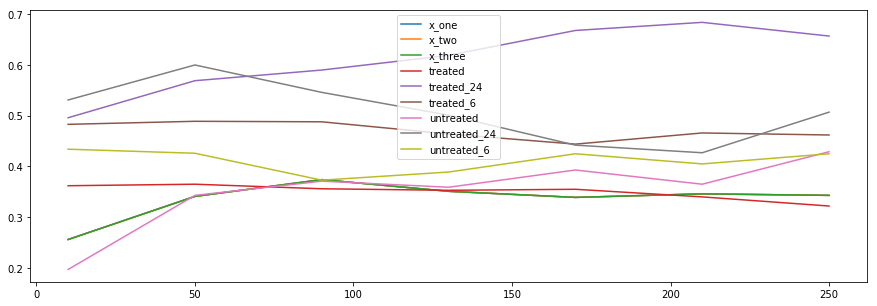

In [502]:
plt.figure(figsize=(15, 5))
plt.plot(condition_1['k=features'], condition_1['test_spear'], label = 'x_one')
plt.plot(condition_2['k=features'], condition_2['test_spear'], label = 'x_two')
plt.plot(condition_3['k=features'], condition_3['test_spear'], label = 'x_three')
plt.plot(condition_4['k=features'], condition_4['test_spear'], label = 'treated')
plt.plot(condition_5['k=features'], condition_5['test_spear'], label = 'treated_24')
plt.plot(condition_6['k=features'], condition_6['test_spear'], label = 'treated_6')
plt.plot(condition_7['k=features'], condition_7['test_spear'], label = 'untreated')
plt.plot(condition_8['k=features'], condition_8['test_spear'], label = 'untreated_24')
plt.plot(condition_9['k=features'], condition_9['test_spear'], label = 'untreated_6')

plt.legend()
# NOTE: x_one, x_two, and x_three line up together perfectly

Not gonna test mutual_info_regression because it didn't appear to perform as well (and took a lot longer)

### Cosine similarty between bioreps (drop features that are NOT similar between reps (below a certain cos sim threshold))
- Idea: Significant genes should not have wildly different measurements in rep 1 vs 2 ---> if a feature in biorep 1 and biorep 2 are NOT within a certain cosine similarity threshold, drop them
- Should be able to forgo search on the X_one and X_three dataframe? --> they will give the same result as X_two because the rows are all the same. ACTUAL RESULT = yes they are all the same
- should also reduce the threshold range (anything below 0.6 was good enough in pre-screen)
    - that was before gridsearch, so maybe make it a little lower

In [559]:
np.arange(0.4, 1.0, 0.08)

array([0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 , 0.88, 0.96])

In [530]:
from sklearn.metrics.pairwise import cosine_similarity

In [580]:


X_frames = ['X_one', 'X_two', 'X_three', 'X_treated', 'X_treated_24', 'X_treated_6',
        'X_untreated', 'X_untreated_24','X_untreated_6' ]
y_frames = ['y', 'y', 'y', 'y_treated', 'y_treated_24', 'y_treated_6',
        'y_untreated', 'y_untreated_24', 'y_untreated_6']

#     X_frames = ['X_one']
#     y_frames = ['y']

dataframe = []
threshold = []
best_params = []
test_spear = []
test_r2 = []
train_spear = []
train_r2 = []
num_columns = []

for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]

    X_cos = x_frame.loc[:]
    X_cos['BioRep'] = train_full['BioRep']                          #add the biorep column to modified df
    reps1 = X_cos[X_cos['BioRep']==1].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep']==2].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])

    for j in np.arange(0.4, 1.0, 0.08):
        drop_point = j
        names = []

        for i in range(len(X_cos.columns)):
            if cosine_similarity(reps2.values[:,i].reshape(1, -1),reps1.values[:,i].reshape(1, -1))[0][0] < drop_point:
                names.append(X_cos.columns[i])

        X_new = X_cos.drop(names,axis=1)

        X_train, X_test , y_train , y_test = train_test_split(X_new, y_frame.values.ravel(), test_size=0.33,random_state=33)
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.1, 1, 10, 50],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4, 6],
                 }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')

        gs.fit(X_train, y_train) 
        scores = pd.DataFrame(gs.cv_results_)
        condition = scores['rank_test_spear_r'] == 1
        df_1 = scores[condition].reset_index(drop = True)


        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(df_1.loc[0, 'params'])
        test_spear.append(round(df_1.loc[0, 'mean_test_spear_r' ], 3))
        test_r2.append(round(df_1.loc[0, 'mean_test_r2'], 3))
        train_spear.append(round(df_1.loc[0, 'mean_train_spear_r'], 3))
        train_r2.append(round(df_1.loc[0, 'mean_train_r2'], 3))
        num_columns.append(len(X_new.columns))



results_cos = pd.DataFrame(list(zip(dataframe, threshold, best_params, test_spear, test_r2, train_spear, 
                                    train_r2, num_columns)), 
                           columns=['x_frame', 'threshold', 'best_params', 'test_spear', 
                                    'test_r2', 'train_spear', 'train_r2', 'n_columns'])


results_cos


/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

x_frame  threshold  \
0            X_one       0.40   
1            X_one       0.48   
2            X_one       0.56   
3            X_one       0.64   
4            X_one       0.72   
5            X_one       0.80   
6            X_one       0.88   
7            X_one       0.96   
8            X_two       0.40   
9            X_two       0.48   
10           X_two       0.56   
11           X_two       0.64   
12           X_two       0.72   
13           X_two       0.80   
14           X_two       0.88   
15           X_two       0.96   
16         X_three       0.40   
17         X_three       0.48   
18         X_three       0.56   
19         X_three       0.64   
20         X_three       0.72   
21         X_three       0.80   
22         X_three       0.88   
23         X_three       0.96   
24       X_treated       0.40   
25       X_treated       0.48   
26       X_treated       0.56   
27       X_treated       0.64   
28       X_treated       0.72   
29       X_treated       0.80   
..             ...        ...   
42     X_treated_6       0.56   
43     X_treated_6       0.64   
44     X_treated_6       0.72   
45     X_treated_6       0.80   
46     X_treated_6       0.88   
47     X_treated_6       0.96   
48     X_untreated       0.40   
49     X_untreated       0.48   
50     X_untreated       0.56   
51     X_untreated       0.64   
52     X_untreated       0.72   
53     X_untreated       0.80   
54     X_untreated       0.88   
55     X_untreated       0.96   
56  X_untreated_24       0.40   
57  X_untreated_24       0.48   
58  X_untreated_24       0.56   
59  X_untreated_24       0.64   
60  X_untreated_24       0.72   
61  X_untreated_24       0.80   
62  X_untreated_24       0.88   
63  X_untreated_24       0.96   
64   X_untreated_6       0.40   
65   X_untreated_6       0.48   
66   X_untreated_6       0.56   
67   X_untreated_6       0.64   
68   X_untreated_6       0.72   
69   X_untreated_6       0.80   
70   X_untreated_6       0.88   
71   X_untreated_6       0.96   

                                          best_params  test_spear  test_r2  \
0   {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.215   -0.069   
1   {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.230   -0.068   
2   {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.213   -0.083   
3   {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.199   -0.023   
4   {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.211   -0.020   
5   {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.212   -0.018   
6   {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...       0.216   -0.029   
7   {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma'...       0.113   -0.385   
8   {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.216   -0.070   
9   {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.228   -0.069   
10  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.211   -0.084   
11  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.199   -0.024   
12  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.207   -0.020   
13  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.206   -0.018   
14  {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...       0.217   -0.030   
15  {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma'...       0.103   -0.488   
16  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.217   -0.070   
17  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.227   -0.069   
18  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.212   -0.084   
19  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.196   -0.024   
20  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.209   -0.020   
21  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.209   -0.018   
22  {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...       0.215   -0.030   
23  {'C': 10, 'degree': 2, 'epsilon': 0.01, 'gamma...       0.113   -0.491   
24  {'C': 0.1,

In [582]:
cos_sim_results = results_cos.loc[:]
cos_sim_results

x_frame  threshold  \
0            X_one       0.40   
1            X_one       0.48   
2            X_one       0.56   
3            X_one       0.64   
4            X_one       0.72   
5            X_one       0.80   
6            X_one       0.88   
7            X_one       0.96   
8            X_two       0.40   
9            X_two       0.48   
10           X_two       0.56   
11           X_two       0.64   
12           X_two       0.72   
13           X_two       0.80   
14           X_two       0.88   
15           X_two       0.96   
16         X_three       0.40   
17         X_three       0.48   
18         X_three       0.56   
19         X_three       0.64   
20         X_three       0.72   
21         X_three       0.80   
22         X_three       0.88   
23         X_three       0.96   
24       X_treated       0.40   
25       X_treated       0.48   
26       X_treated       0.56   
27       X_treated       0.64   
28       X_treated       0.72   
29       X_treated       0.80   
..             ...        ...   
42     X_treated_6       0.56   
43     X_treated_6       0.64   
44     X_treated_6       0.72   
45     X_treated_6       0.80   
46     X_treated_6       0.88   
47     X_treated_6       0.96   
48     X_untreated       0.40   
49     X_untreated       0.48   
50     X_untreated       0.56   
51     X_untreated       0.64   
52     X_untreated       0.72   
53     X_untreated       0.80   
54     X_untreated       0.88   
55     X_untreated       0.96   
56  X_untreated_24       0.40   
57  X_untreated_24       0.48   
58  X_untreated_24       0.56   
59  X_untreated_24       0.64   
60  X_untreated_24       0.72   
61  X_untreated_24       0.80   
62  X_untreated_24       0.88   
63  X_untreated_24       0.96   
64   X_untreated_6       0.40   
65   X_untreated_6       0.48   
66   X_untreated_6       0.56   
67   X_untreated_6       0.64   
68   X_untreated_6       0.72   
69   X_untreated_6       0.80   
70   X_untreated_6       0.88   
71   X_untreated_6       0.96   

                                          best_params  test_spear  test_r2  \
0   {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.215   -0.069   
1   {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.230   -0.068   
2   {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.213   -0.083   
3   {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.199   -0.023   
4   {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.211   -0.020   
5   {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.212   -0.018   
6   {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...       0.216   -0.029   
7   {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma'...       0.113   -0.385   
8   {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.216   -0.070   
9   {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.228   -0.069   
10  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.211   -0.084   
11  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.199   -0.024   
12  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.207   -0.020   
13  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.206   -0.018   
14  {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...       0.217   -0.030   
15  {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma'...       0.103   -0.488   
16  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.217   -0.070   
17  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.227   -0.069   
18  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...       0.212   -0.084   
19  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.196   -0.024   
20  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.209   -0.020   
21  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...       0.209   -0.018   
22  {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...       0.215   -0.030   
23  {'C': 10, 'degree': 2, 'epsilon': 0.01, 'gamma...       0.113   -0.491   
24  {'C': 0.1,

In [583]:
condition_1 = cos_sim_results[cos_sim_results['x_frame'] == 'X_one']
condition_2 = cos_sim_results[cos_sim_results['x_frame'] == 'X_two']
condition_3 = cos_sim_results[cos_sim_results['x_frame'] == 'X_three']
condition_4 = cos_sim_results[cos_sim_results['x_frame'] == 'X_treated']
condition_5 = cos_sim_results[cos_sim_results['x_frame'] == 'X_treated_24']
condition_6 = cos_sim_results[cos_sim_results['x_frame'] == 'X_treated_6']
condition_7 = cos_sim_results[cos_sim_results['x_frame'] == 'X_untreated']
condition_8 = cos_sim_results[cos_sim_results['x_frame'] == 'X_untreated_24']
condition_9 = cos_sim_results[cos_sim_results['x_frame'] == 'X_untreated_6']
# condition_1

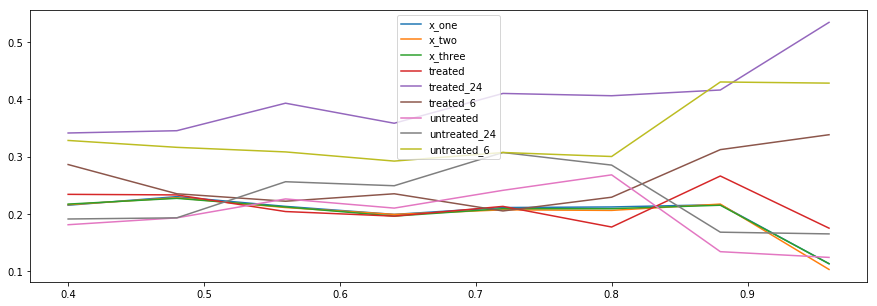

In [592]:
plt.figure(figsize=(15, 5))
plt.plot(condition_1['threshold'], condition_1['test_spear'], label = 'x_one')
plt.plot(condition_2['threshold'], condition_2['test_spear'], label = 'x_two')
plt.plot(condition_3['threshold'], condition_3['test_spear'], label = 'x_three')
plt.plot(condition_4['threshold'], condition_4['test_spear'], label = 'treated')
plt.plot(condition_5['threshold'], condition_5['test_spear'], label = 'treated_24')
plt.plot(condition_6['threshold'], condition_6['test_spear'], label = 'treated_6')
plt.plot(condition_7['threshold'], condition_7['test_spear'], label = 'untreated')
plt.plot(condition_8['threshold'], condition_8['test_spear'], label = 'untreated_24')
plt.plot(condition_9['threshold'], condition_9['test_spear'], label = 'untreated_6')

plt.legend()
# NOTE: x_one, x_two, and x_three line up *almost* together perfectly

### Cosine similarty between treatments (drop things that are highly similar)
- Idea: maybe some important features will behave differently in untreated vs treated
    - unlike rep1 vs rep1, important features will likely have different measurements in the treated vs untreated samples 
    - drop features that have a cos-sim score above the threshold (if a feature in untreated vs treated has a low similarity, keep it)
- X_one, X_two, and X_three should all give the same result --> I'll test just to make sure

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
# cos similarity for untreated vs treated


X_frames = ['X_one', 'X_two','X_three']
y_frames = ['y', 'y', 'y']

dataframe = []
threshold = []
best_params = []
test_spear = []
test_r2 = []
train_spear = []
train_r2 = []
num_columns = []

for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]

    
    if 'Treatment' not in x_frame.columns:     #for X_one
        
        X_cos = x_frame.loc[:]
        X_cos['Treatment'] = train_full['Treatment']
        treat1 = X_cos[X_cos['Treatment']==1].drop(columns = ['Treatment'])
        treat0 = X_cos[X_cos['Treatment']==0].drop(columns = ['Treatment'])
        X_cos = X_cos.drop(columns= ['Treatment'])
    
    else:                                      #for X_two, X_three
        X_cos = x_frame.loc[:]
        treat1 = X_cos[X_cos['Treatment']==1]
        treat0 = X_cos[X_cos['Treatment']==0]



    for j in np.arange(-.2, 0.91, 0.1):   #lower than -0.2 might have 0 features leftover
        drop_point = j
        names = []

        for i in range(len(X_cos.columns)):
            if cosine_similarity(treat1.values[:,i].reshape(1, -1),treat0.values[:,i].reshape(1, -1))[0][0] > drop_point:
                names.append(X_cos.columns[i])

        X_new = X_cos.drop(names,axis=1)
        
        X_train, X_test , y_train , y_test = train_test_split(X_new, y_frame.values.ravel(), test_size=0.33,random_state=33)
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.1, 1, 10, 50],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4, 6],
                 }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')

        gs.fit(X_train, y_train) 
        scores = pd.DataFrame(gs.cv_results_)
        condition = scores['rank_test_spear_r'] == 1
        df_1 = scores[condition].reset_index(drop = True)


        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(df_1.loc[0, 'params'])
        test_spear.append(round(df_1.loc[0, 'mean_test_spear_r' ], 3))
        test_r2.append(round(df_1.loc[0, 'mean_test_r2'], 3))
        train_spear.append(round(df_1.loc[0, 'mean_train_spear_r'], 3))
        train_r2.append(round(df_1.loc[0, 'mean_train_r2'], 3))
        num_columns.append(len(X_new.columns))



results_cos = pd.DataFrame(list(zip(dataframe, threshold, best_params, test_spear, test_r2, train_spear, 
                                    train_r2, num_columns)), 
                           columns=['x_frame', 'threshold', 'best_params', 'test_spear', 
                                    'test_r2', 'train_spear', 'train_r2', 'n_columns'])
results_cos

x_frame  threshold                                        best_params  \
0     X_one       -0.2  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
1     X_one       -0.1  {'C': 10, 'degree': 2, 'epsilon': 0.2, 'gamma'...   
2     X_one        0.0  {'C': 50, 'degree': 4, 'epsilon': 0.2, 'gamma'...   
3     X_one        0.1  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
4     X_one        0.2  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
5     X_one        0.3  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...   
6     X_one        0.4  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
7     X_one        0.5  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
8     X_one        0.6  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
9     X_one        0.7  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
10    X_one        0.8  {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...   
11    X_one        0.9  {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma':...   
12    X_two       -0.2  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
13    X_two       -0.1  {'C': 10, 'degree': 2, 'epsilon': 0.2, 'gamma'...   
14    X_two        0.0  {'C': 50, 'degree': 4, 'epsilon': 0.2, 'gamma'...   
15    X_two        0.1  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
16    X_two        0.2  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
17    X_two        0.3  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...   
18    X_two        0.4  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
19    X_two        0.5  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
20    X_two        0.6  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
21    X_two        0.7  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
22    X_two        0.8  {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...   
23    X_two        0.9  {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma':...   
24  X_three       -0.2  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
25  X_three       -0.1  {'C': 10, 'degree': 2, 'epsilon': 0.2, 'gamma'...   
26  X_three        0.0  {'C': 50, 'degree': 4, 'epsilon': 0.2, 'gamma'...   
27  X_three        0.1  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
28  X_three        0.2  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
29  X_three        0.3  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...   
30  X_three        0.4  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
31  X_three        0.5  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
32  X_three        0.6  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
33  X_three        0.7  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
34  X_three        0.8  {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...   
35  X_three        0.9  {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma':...   

    test_spear  test_r2  train_spear  train_r2  n_columns  
0        0.181   -0.027        0.338    -0.000         20  
1        0.358   -0.016        0.833     0.418        179  
2        0.338   -0.030        0.867     0.431        749  
3        0.336    0.020        0.808     0.310       1555  
4        0.290   -0.015        0.849     0.464       2236  
5        0.252   -0.054        0.925     0.628       2795  
6        0.265   -0.006        0.747     0.236       3375  
7        0.269   -0.000        0.777     0.291       3868  
8        0.256   -0.006        0.797     0.334       4298  
9        0.246   -0.022        0.822     0.407       4744  
10       0.233   -0.037        0.876     0.522       5148  
11       0.227   -0.021        0.830     0.398       5430  
12       0.181   -0.027        0.338    -0.000         20  
13       0.358   -0.016        0.833     0.418        179  
14       0.339   -0.030        0.867     0.431        750  
15       0.335    0.019        0.808     0.311       1556  
16       0.288   -0.015        0.850     0.464       2237  
17       0.250   -0.054        0.925     0.628       2796  
18       0.265

In [27]:
condition_1 = results_cos[results_cos['x_frame'] == 'X_one']
condition_2 = results_cos[results_cos['x_frame'] == 'X_two']
condition_3 = results_cos[results_cos['x_frame'] == 'X_three']
condition_3

x_frame  threshold                                        best_params  \
24  X_three       -0.2  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
25  X_three       -0.1  {'C': 10, 'degree': 2, 'epsilon': 0.2, 'gamma'...   
26  X_three        0.0  {'C': 50, 'degree': 4, 'epsilon': 0.2, 'gamma'...   
27  X_three        0.1  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
28  X_three        0.2  {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...   
29  X_three        0.3  {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma'...   
30  X_three        0.4  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
31  X_three        0.5  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
32  X_three        0.6  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
33  X_three        0.7  {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma...   
34  X_three        0.8  {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...   
35  X_three        0.9  {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma':...   

    test_spear  test_r2  train_spear  train_r2  n_columns  
24       0.181   -0.027        0.338    -0.000         20  
25       0.358   -0.016        0.833     0.418        179  
26       0.339   -0.030        0.867     0.431        750  
27       0.335    0.019        0.808     0.311       1556  
28       0.288   -0.015        0.850     0.464       2237  
29       0.250   -0.054        0.925     0.628       2796  
30       0.265   -0.006        0.747     0.236       3376  
31       0.266   -0.001        0.776     0.291       3869  
32       0.254   -0.007        0.798     0.334       4299  
33       0.245   -0.022        0.823     0.407       4745  
34       0.233   -0.038        0.876     0.523       5149  
35       0.224   -0.021        0.831     0.398       5431

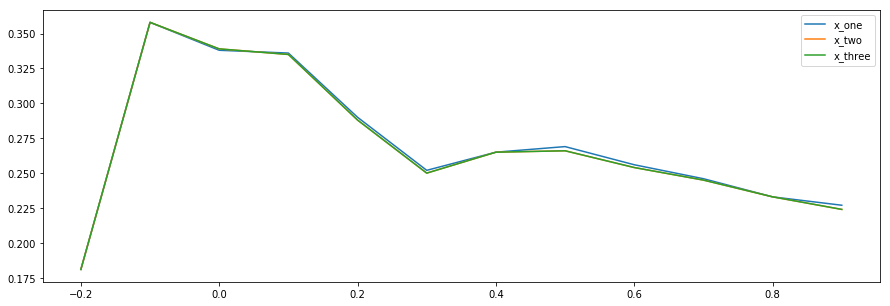

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(condition_1['threshold'], condition_1['test_spear'], label = 'x_one')
plt.plot(condition_2['threshold'], condition_2['test_spear'], label = 'x_two')
plt.plot(condition_3['threshold'], condition_3['test_spear'], label = 'x_three')
plt.legend()
plt.show()

NOTE: with a threshold lower than -0.2, there is close to 0 features remaining

## #4. For Random Forest model, Gridsearch the best params for every dataframe

In [22]:
X_frames = ['X_one', 'X_two', 'X_three', 'X_treated', 'X_treated_24', 'X_untreated', 'X_untreated_24' ]
y_frames = ['y', 'y', 'y', 'y_treated', 'y_treated_24', 'y_untreated', 'y_untreated_24']


dataframe = []
best_params = []
test_spear = []
test_r2 = []
train_spear = []
train_r2 = []


for x in list(zip(X_frames, y_frames)):
    
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]

    X_train, X_test, y_train, y_test = train_test_split(x_frame, y_frame.values.ravel(), test_size = 0.33, random_state = 33)


    
    rfr = RandomForestRegressor()
    
    params = {        
                   'max_features': [50, 100, 200, 300, 'auto'],
                   'n_estimators': [50, 100, 200],
                'min_samples_leaf': [2, 5, 10, 50],


                   'random_state': [8],
#                       'oob_score': [True],
             }


    scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r)}

    gs = GridSearchCV(rfr, param_grid= params,  cv=3, verbose = 0, 
                      return_train_score=True, scoring = scoring, refit = 'spear_r')

    gs.fit(X_train, y_train) 
    scores = pd.DataFrame(gs.cv_results_)
    condition = scores['rank_test_spear_r'] == 1
    df_1 = scores[condition].reset_index(drop = True)


    dataframe.append(x[0])
    best_params.append(df_1.loc[0, 'params'])
    test_spear.append(round(df_1.loc[0, 'mean_test_spear_r' ], 3))
    test_r2.append(round(df_1.loc[0, 'mean_test_r2'], 3))
    train_spear.append(round(df_1.loc[0, 'mean_train_spear_r'], 3))
    train_r2.append(round(df_1.loc[0, 'mean_train_r2'], 3))




random_forest_results = pd.DataFrame(list(zip(dataframe, best_params, test_spear, test_r2, train_spear, 
                                    train_r2)), 
                           columns=['x_frame', 'best_params', 'test_spear', 
                                    'test_r2', 'train_spear', 'train_r2'])
random_forest_results




/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/amytaylor/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: inv

NameError: name 'num_columns' is not defined

In [23]:
random_forest_results = pd.DataFrame(list(zip(dataframe, best_params, test_spear, test_r2, train_spear, 
                                    train_r2)), 
                           columns=['x_frame', 'best_params', 'test_spear', 
                                    'test_r2', 'train_spear', 'train_r2'])
random_forest_results

x_frame                                        best_params  \
0           X_one  {'max_features': 'auto', 'min_samples_leaf': 2...   
1           X_two  {'max_features': 100, 'min_samples_leaf': 2, '...   
2         X_three  {'max_features': 300, 'min_samples_leaf': 2, '...   
3       X_treated  {'max_features': 50, 'min_samples_leaf': 2, 'n...   
4    X_treated_24  {'max_features': 50, 'min_samples_leaf': 5, 'n...   
5     X_untreated  {'max_features': 200, 'min_samples_leaf': 2, '...   
6  X_untreated_24  {'max_features': 'auto', 'min_samples_leaf': 1...   

   test_spear  test_r2  train_spear  train_r2  
0       0.103   -0.087        0.967     0.824  
1       0.096   -0.119        0.965     0.805  
2       0.164   -0.063        0.967     0.811  
3       0.106   -0.160        0.951     0.756  
4       0.122   -0.288        0.883     0.492  
5      -0.007   -0.184        0.957     0.774  
6       0.062   -0.193        0.827     0.179

In [24]:
random_forest_results['best_params'].values

array([{'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 100, 'random_state': 8},
       {'max_features': 100, 'min_samples_leaf': 2, 'n_estimators': 50, 'random_state': 8},
       {'max_features': 300, 'min_samples_leaf': 2, 'n_estimators': 50, 'random_state': 8},
       {'max_features': 50, 'min_samples_leaf': 2, 'n_estimators': 50, 'random_state': 8},
       {'max_features': 50, 'min_samples_leaf': 5, 'n_estimators': 50, 'random_state': 8},
       {'max_features': 200, 'min_samples_leaf': 2, 'n_estimators': 50, 'random_state': 8},
       {'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 200, 'random_state': 8}],
      dtype=object)

## #5. For Random Forest model with feature selection,  Gridsearch the best params for every dataframe